https://medium.com/@ankitvashisht12/classifying-dog-breed-using-pytorch-abc9f3c5128a

In [1]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, random_split, DataLoader
import torch
import torch.nn as nn # layer들을 호출하기 위해서
import numpy as np
import torch.optim as optim # optimization method를 사용하기 위해서
import torch.nn.init as init # weight initialization 해주기 위해서
from tqdm import tqdm

import os
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
from parallel import DataParallelModel,DataParallelCriterion
# %matplotlib inline

In [2]:
batch_size = 128
num_workers = 2 * torch.cuda.device_count()
print(num_workers)
print(os.cpu_count())

14
48


In [3]:
train_set = ImageFolder(root='./stanford/train')
test_set = ImageFolder(root='./stanford/test')

n_class = len(train_set.classes)


dataset_size = len(train_set)
val_pct = 0.2
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size
test_size = len(test_set)

train_size, val_size, test_size

(9600, 2400, 8580)

In [4]:
train_ds, val_ds = random_split(train_set, [train_size, val_size])
len(train_ds), len(val_ds)

(9600, 2400)

In [5]:
# Image Transform을 지정합니다.
train_transform = transforms.Compose([
#        transforms.Resize((128, 128)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(256, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

val_transform = transforms.Compose([
#     transforms.Resize((128, 128)),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
#     transforms.Resize((128, 128)), 
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [6]:
# 이미지 폴더로부터 데이터를 로드합니다.
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label
        
        
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_set, test_transform)

In [7]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size*2, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=num_workers, pin_memory=True)

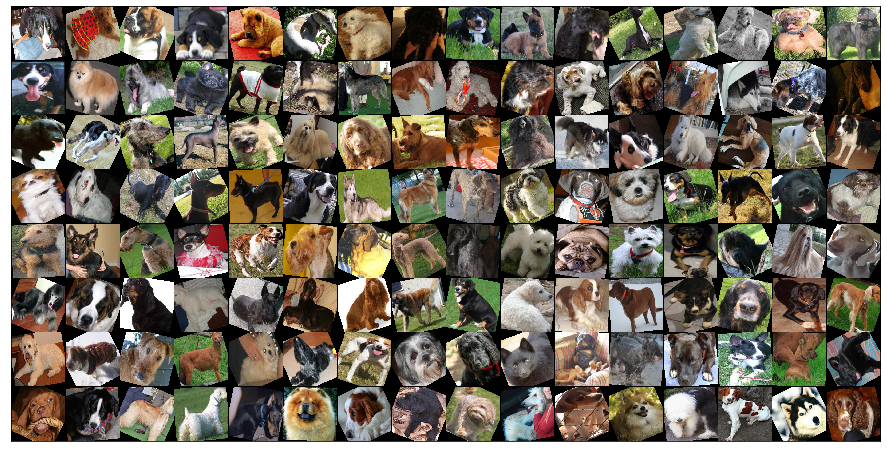

In [8]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break
        
show_batch(train_loader)

In [8]:
# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
images, classes = next(iter(train_loader))

images.shape, classes.shape

(torch.Size([128, 3, 256, 256]), torch.Size([128]))

In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [10]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
#         loss = DataParallelCriterion(loss) 
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
#         loss = DataParallelCriterion(loss) 
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [11]:
class DogBreedPretrainedResnet152(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        self.network = nn.DataParallel(self.network,
                                       device_ids=[0,1,2,3])
        
    def forward(self, xb):
        return self.network(xb)
    
class DogBreedPretrainedResnet50(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        self.network = nn.DataParallel(self.network,
                                       device_ids=[0,1,2,3])
        
    def forward(self, xb):
        return self.network(xb)
    
class DogBreedPretrainedWRN101(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.wide_resnet101_2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 120),
            nn.LogSoftmax(dim=1)
        )
        self.network = nn.DataParallel(self.network,
                                       device_ids=[0,1,2,3])
        
    def forward(self, xb):
        return self.network(xb)

In [12]:
class MyDataParallel(nn.DataParallel):
    def __getattr__(self,name):
        return getattr(self.module,name)

In [13]:
model = DogBreedPretrainedWRN101()
model

/home/miller198/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/miller198/.local/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DogBreedPretrainedResnet152(
  (network): DataParallel(
    (module): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

    
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [16]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)


# moving model to gpu
to_device(model, device);

cuda


In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [18]:
evaluate(model, val_dl) 

{'val_loss': 4.8470563888549805, 'val_acc': 0.008072917349636555}

In [19]:
opt_func = torch.optim.SGD
num_epoch = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [20]:
history = fit_one_cycle(num_epoch, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)

100%|██████████| 75/75 [01:15<00:00,  1.00s/it]


Epoch [0] : train_loss: 4.6900, val_loss: 4.3187, val_acc: 0.3020


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


Epoch [1] : train_loss: 3.3037, val_loss: 1.3975, val_acc: 0.7568


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [2] : train_loss: 1.1909, val_loss: 0.6259, val_acc: 0.8641


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [3] : train_loss: 0.6421, val_loss: 0.5190, val_acc: 0.8438


100%|██████████| 75/75 [01:13<00:00,  1.03it/s]


Epoch [4] : train_loss: 0.4650, val_loss: 0.5592, val_acc: 0.8368


100%|██████████| 75/75 [01:13<00:00,  1.01it/s]


Epoch [5] : train_loss: 0.3453, val_loss: 0.4424, val_acc: 0.8672


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [6] : train_loss: 0.2766, val_loss: 0.5705, val_acc: 0.8263


100%|██████████| 75/75 [01:13<00:00,  1.03it/s]


Epoch [7] : train_loss: 0.2143, val_loss: 0.4447, val_acc: 0.8681


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [8] : train_loss: 0.1671, val_loss: 0.4291, val_acc: 0.8737


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [9] : train_loss: 0.1331, val_loss: 0.4206, val_acc: 0.8710


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [10] : train_loss: 0.1040, val_loss: 0.4007, val_acc: 0.8827


100%|██████████| 75/75 [01:12<00:00,  1.03it/s]


Epoch [11] : train_loss: 0.0840, val_loss: 0.3942, val_acc: 0.8862


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [12] : train_loss: 0.0687, val_loss: 0.4224, val_acc: 0.8845


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [13] : train_loss: 0.0614, val_loss: 0.4136, val_acc: 0.8844


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [14] : train_loss: 0.0491, val_loss: 0.4051, val_acc: 0.8865


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [15] : train_loss: 0.0411, val_loss: 0.3972, val_acc: 0.8917


100%|██████████| 75/75 [01:14<00:00,  1.01it/s]


Epoch [16] : train_loss: 0.0362, val_loss: 0.3944, val_acc: 0.8930


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [17] : train_loss: 0.0312, val_loss: 0.3966, val_acc: 0.8910


100%|██████████| 75/75 [01:14<00:00,  1.01it/s]


Epoch [18] : train_loss: 0.0285, val_loss: 0.3911, val_acc: 0.8953


100%|██████████| 75/75 [01:14<00:00,  1.01it/s]


Epoch [19] : train_loss: 0.0294, val_loss: 0.3892, val_acc: 0.8964


In [22]:
num_epoch = 5
max_lr = 0.001
weight_decay = 1e-6

history += fit_one_cycle(num_epoch, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)


100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [0] : train_loss: 0.0288, val_loss: 0.3978, val_acc: 0.8935



100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [1] : train_loss: 0.0289, val_loss: 0.3993, val_acc: 0.8885



100%|██████████| 75/75 [01:13<00:00,  1.03it/s]


Epoch [2] : train_loss: 0.0287, val_loss: 0.3951, val_acc: 0.8862



100%|██████████| 75/75 [01:14<00:00,  1.00it/s]


Epoch [3] : train_loss: 0.0287, val_loss: 0.3981, val_acc: 0.8953



100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [4] : train_loss: 0.0261, val_loss: 0.3934, val_acc: 0.8943


In [23]:
num_epoch = 3
max_lr = 0.0001

history += fit_one_cycle(num_epoch, max_lr, model, train_dl, val_dl, weight_decay, grad_clip, opt_func)


100%|██████████| 75/75 [01:14<00:00,  1.01it/s]


Epoch [0] : train_loss: 0.0264, val_loss: 0.3968, val_acc: 0.8913



100%|██████████| 75/75 [01:13<00:00,  1.01it/s]


Epoch [1] : train_loss: 0.0268, val_loss: 0.3983, val_acc: 0.8918



100%|██████████| 75/75 [01:13<00:00,  1.02it/s]


Epoch [2] : train_loss: 0.0252, val_loss: 0.3923, val_acc: 0.8900


In [24]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

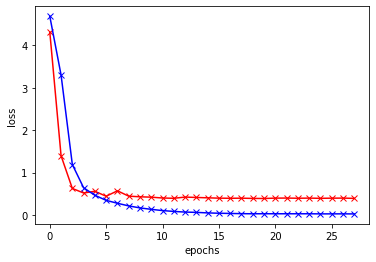

In [25]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

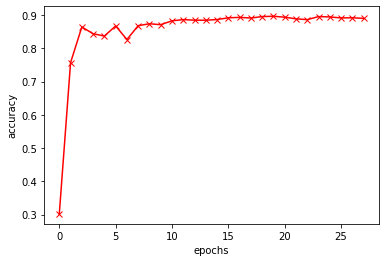

In [26]:
plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

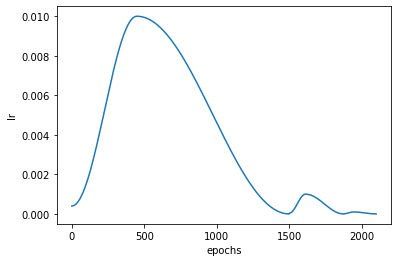

In [27]:
lrs = np.concatenate([x.get('lrs', []) for x in history])
plt.xlabel('epochs')
plt.ylabel('lr')
plt.plot(lrs)
plt.show()

In [28]:
def predict_single(img, label):
    xb = img.unsqueeze(0) # adding extra dimension
    xb = to_device(xb, device)
    preds = model(xb)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()

In [29]:
breeds = []

def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in train_set.classes:
    breeds.append(rename(n))

Actual : American Staffordshire terrier  | Predicted : American Staffordshire terrier


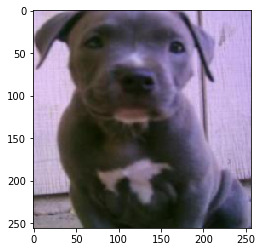

In [30]:
predict_single(*test_dataset[2427])

In [31]:
test_dl = DeviceDataLoader(test_loader, device)

In [32]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.36982032656669617, 'val_acc': 0.8947679996490479}

In [33]:
torch.save(model, './models/' + 'dataloader-2_WRnet101_Acc89.pt')